In [1]:
import os
import sys
import gc
import json
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from typing import List, NoReturn, Union, Tuple, Optional, Set, Dict, Any

import lightgbm as lgb
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from tqdm import tqdm

tqdm.pandas()

from load_data import load_train_valid_data, load_live_data
from transformer import (
    EraLoader,
    #   Transformer,
)

import logging

logging.getLogger("lightning").setLevel(logging.ERROR)

logger = logging.getLogger(__name__)

# torch.set_float32_matmul_precision('medium') # default: 'low'

# fix random seeds for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# python version
print("python version: %s" % (sys.version))

python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:34:57) [MSC v.1936 64 bit (AMD64)]


In [2]:
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
train, valid = load_train_valid_data("medium")
train_eras = (
    train["era_int"].unique().tolist()
    + valid["era_int"].unique()[: int(len(valid["era"].unique()) * 0.4)].tolist()
)

validation_eras = (
    valid["era_int"].unique().tolist()[int(len(valid["era"].unique()) * 0.6) :]
)

feature_names = [f for f in train.columns if "feature_" in f]
target_names = [f for f in train.columns if "target_" in f]
PRIMARY_TARGET = "target_cyrus_v4_20"

with open("../data/features.json") as f:
    features_meta = json.load(f)
medium_feature_set = features_meta["feature_sets"]["medium"]
medium_feature_set_index = [feature_names.index(f) for f in medium_feature_set]

e:\numerai_research\v4_2_rain\src\load_data.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df["era_int"] = train_df["era"].astype(int)
e:\numerai_research\v4_2_rain\src\load_data.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_df["era_int"] = valid_df["era"].astype(int)


In [3]:
def train_model_farm(
    df_train: pd.DataFrame, feature_names: List[str], target_names: List[str]
) -> Dict:
    models = {}

    models["model_1"] = Ridge(alpha=1.0, fit_intercept=True, random_state=42)
    models["model_2"] = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        n_jobs=-1,
    )
    models["model_3"] = lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.01,
        max_depth=4,
        random_state=42,
        n_jobs=-1,
    )
    models["model_4"] = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=4,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
    )
    models["model_5"] = lgb.LGBMRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=3,
        colsample_bytree=0.5,
        random_state=42,
        n_jobs=-1,
    )

    for model_name, model in models.items():
        print(f"Training {model_name}")
        model.fit(df_train[feature_names], df_train[target_names])
        print(f"Finished training {model_name}")

    return models


def make_model_farm_predictions(models, df, feature_names):
    predictions = {}
    for model_name, model in models.items():
        predictions[model_name] = model.predict(df[feature_names])

    # add random predictions
    predictions["model_99"] = np.random.normal(0, 1, size=len(df))  # random predictions
    return predictions


def unif(df):
    """from example scripts"""
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

In [4]:
if os.path.exists("trained_models_farm.pkl"):
    trained_models = pd.read_pickle("trained_models_farm.pkl")
else:
    trained_models = train_model_farm(
        train, medium_feature_set, target_names=PRIMARY_TARGET
    )
    # save models
    pd.to_pickle(trained_models, "trained_models_farm.pkl")

train_predictions = make_model_farm_predictions(
    trained_models, train, medium_feature_set
)
valid_predictions = make_model_farm_predictions(
    trained_models, valid, medium_feature_set
)

In [5]:
train_predictions_df = pd.DataFrame(train_predictions).add_prefix("predictions_")
valid_predictions_df = pd.DataFrame(valid_predictions).add_prefix("predictions_")

In [216]:
train_predictions_df = pd.read_parquet("E:/numerai_research/v4_2_rain/eraformer/preds_train_20231008104206_100.parquet")
valid_predictions_df = pd.read_parquet("E:/numerai_research/v4_2_rain/eraformer/preds_valid_20231008104206_100.parquet")

In [238]:
train_predictions_df["era"] = train["era"].values
valid_predictions_df["era"] = valid["era"].values

train_predictions_df["era_int"] = train["era_int"].values
valid_predictions_df["era_int"] = valid["era_int"].values

train_predictions_df["id"] = train.index.values
valid_predictions_df["id"] = valid.index.values

train_predictions_df[target_names] = train[target_names].values
valid_predictions_df[target_names] = valid[target_names].values
gc.collect()

prediction_cols = [c for c in train_predictions_df.columns if "prediction_" in c]

for _col in prediction_cols:
    train_predictions_df[_col] = train_predictions_df.groupby("era_int")[
        _col
    ].transform(lambda x: unif(x))
    valid_predictions_df[_col] = valid_predictions_df.groupby("era_int")[
        _col
    ].transform(lambda x: unif(x))

In [239]:
live_example_preds = pd.read_parquet("../data/live_example_preds.parquet")
validation_example_preds = pd.read_parquet("../data/validation_example_preds.parquet")
meta_model = pd.read_parquet("../data/meta_model.parquet")

valid["example_preds"] = validation_example_preds
diagnosis = valid[["era_int", "example_preds", PRIMARY_TARGET]].reset_index()
diagnosis = diagnosis.merge(valid_predictions_df[["id"] + prediction_cols], on="id")
combined = pd.merge(diagnosis, meta_model, on=["id"], how="right").dropna(axis=0)

for _col in [["example_preds", "numerai_meta_model"]]:
    combined[_col] = combined.groupby("era_int")[_col].transform(lambda x: unif(x))

In [240]:
import torch


def pearsonr(x, y):
    mx = x.mean()
    my = y.mean()
    xm, ym = x - mx, y - my
    r_num = (xm * ym).sum()
    r_den = torch.sqrt((xm**2).sum() * (ym**2).sum())

    r = r_num / r_den
    return r

In [248]:
INITIAL_STAKE = torch.randint(10, 100000, [len(prediction_cols), ])
INITIAL_STAKE

tensor([ 2501, 82368, 49464, 17805, 59087, 11361, 60393, 47129, 50191, 78167,
        48278, 62076, 41095, 53320, 43330, 25402, 95141, 82229, 51420, 57665,
        20594, 46922, 16924, 43134, 66839, 56081, 62481, 30308, 13755, 12594,
        50009, 78924, 61020, 27666, 24707, 85199, 18011, 83607, 25470, 76957,
         8417, 19772, 25622, 61250, 24699, 84908, 10406, 81350,  8325, 87486,
        69915, 66885, 81424, 12422, 92955, 54108, 46672, 99371, 97805, 54428,
        34077, 72306, 46386, 91000, 65195, 38424, 69768, 24706, 26063, 18519,
        14211, 49595, 10083, 30492, 97237, 70159,  2397, 84314, 80917, 68925,
        98046, 16879, 90030, 19546, 48516, 68608,  7808, 57659, 99184, 38600,
        90013, 46308, 32495, 13687,   487,  2520, 76282,  7054, 54713,  6532,
        48004, 85200, 81623, 13759, 53872, 57830, 83024, 53108, 68005, 31105,
        78715, 25893, 57036, 68072,  6970, 15159, 88990, 13953, 13893,  3632,
        51572,  7050, 95457, 57130, 68607, 85732, 44937, 15473, 

In [254]:
metrics = {
    "era": [],
    "swmm_corr": [],
    "og_mm_corr": [],
    "example_model_corr": [],
    "iswmm_corr": [],
}
model_performance = {name: [] for name in prediction_cols}
model_performance["era"] = []
model_stake_grads = {name: [] for name in prediction_cols}
model_stake_grads["era"] = []
model_additive_stake_grads = {name: [] for name in prediction_cols}
model_additive_stake_grads["era"] = []

SCALE_STAKE_GRADS = True
RANDOM_DROPOUT = False
ADJUST_STAKES = True
PAYOUT_FACTOR = 0.5


def calculate_correlation(predictions, targets):
    return pearsonr(predictions, targets)


def calculate_additive_corr_diff(
    example_preds, predictions, random_stake, targets, example_model_corr
):
    additive = (example_preds + predictions * random_stake) / 2
    return pearsonr(additive, targets) - example_model_corr


def update_stake(random_stake, stake_grad, correlation_vector):
    return (
        (
            random_stake
            + random_stake
            * torch.clip(
                PAYOUT_FACTOR * (1 * stake_grad + 1 * correlation_vector), -0.25, 0.25
            )
        )
        .detach()
        .requires_grad_(True)
    )


for iix, (_era, _group) in tqdm(enumerate(combined.groupby("era_int"))):
    # 1. convert predictions to torch tensors
    example_minus_metamodel = unif(
        _group["example_preds"] - _group["numerai_meta_model"]
    )  # [n_rows, 1]
    example_minus_metamodel = torch.tensor(
        example_minus_metamodel.values, requires_grad=True
    )  # [n_rows, 1]
    predictions = torch.tensor(
        _group[prediction_cols].values, requires_grad=True
    )  # [n_rows, n_models]
    example_preds = torch.tensor(
        _group["example_preds"].values, requires_grad=True
    )  # [n_rows, 1]
    targets = torch.tensor(
        _group[PRIMARY_TARGET].values, requires_grad=True
    )  # [n_rows, 1]
    meta_model_preds = torch.tensor(
        _group["numerai_meta_model"].values, requires_grad=True
    )  # [n_rows, 1]

    # 2. Initialize stakes
    if iix == 0:
        initial_stake = (
            INITIAL_STAKE  # torch.randint(10, 1000, (predictions.shape[1],))
        )
        random_stake = initial_stake.clone().float().detach().requires_grad_(True)

    # 3. Calculate SWMM and ISWMM:
    # Stake Weighted Meta Model: stake is updated
    # Initial Stake Weighted Meta Model: stake is not updated
    SWMM = torch.sum(predictions * random_stake, axis=1)
    ISWMM = torch.sum(predictions * initial_stake, axis=1)

    swmm_corr = calculate_correlation(SWMM, targets)
    iswmm_corr = calculate_correlation(ISWMM, targets)
    og_meta_model_corr = calculate_correlation(meta_model_preds, targets)
    example_model_corr = calculate_correlation(example_preds, targets)

    # 4. each model's (or predictions) correlation with the target
    _correlation_vector = torch.zeros(predictions.shape[1], requires_grad=False)
    for _col in range(len(prediction_cols)):
        _key = prediction_cols[_col]
        _correlation = calculate_correlation(predictions[:, _col], targets)
        _correlation_vector[_col] = _correlation
        model_performance[_key].append(_correlation.item())

    # 5. Each model's additive correlation with the example model
    for _col in range(len(prediction_cols)):
        _key = prediction_cols[_col]
        model_additive_corr_diff = calculate_additive_corr_diff(
            example_preds,
            predictions[:, _col],
            random_stake[_col],
            targets,
            example_model_corr,
        )
        model_additive_stake_grads[_key].append(model_additive_corr_diff.item())

    # 6. gradient for each prediction's stake against the loss: dL/dp, L:swmm_corr
    random_stake.grad = None
    swmm_corr.backward(retain_graph=True)

    # stake gradient: dL/ds, L:swmm_corr, s:stake
    _stake_grad = random_stake.grad

    # can't really change since the model is fixed
    _pred_grad = predictions.grad

    # scale stake gradients
    if SCALE_STAKE_GRADS:
        _stake_grad = _stake_grad * 1.0 / torch.norm(_stake_grad)

    # add _stake grads to modle_grads array
    for _col in range(len(prediction_cols)):
        _key = prediction_cols[_col]
        model_stake_grads[_key].append(_stake_grad[_col].item())

    # randomly make bool mask for which predictions to update
    if RANDOM_DROPOUT:
        mask = torch.rand(predictions.shape[1]) > 0.5
        _stake_grad = _stake_grad * mask

    # 7. update stake based on stake gradient (Which is TC?) and correlation of the model
    if ADJUST_STAKES:
        random_stake = update_stake(random_stake, _stake_grad, _correlation_vector)
        # print((1 * _stake_grad + 1 * _correlation_vector) * PAYOUT_FACTOR)

    metrics["era"].append(_era)
    model_stake_grads["era"].append(_era)
    model_performance["era"].append(_era)
    model_additive_stake_grads["era"].append(_era)

    metrics["swmm_corr"].append(swmm_corr.item())
    metrics["iswmm_corr"].append(iswmm_corr.item())
    metrics["og_mm_corr"].append(og_meta_model_corr.item())
    metrics["example_model_corr"].append(example_model_corr.item())

metrics = pd.DataFrame(metrics)
model_performance = pd.DataFrame(model_performance)
model_stake_grads = pd.DataFrame(model_stake_grads)
model_additive_stake_grads = pd.DataFrame(model_additive_stake_grads)

0it [00:00, ?it/s]

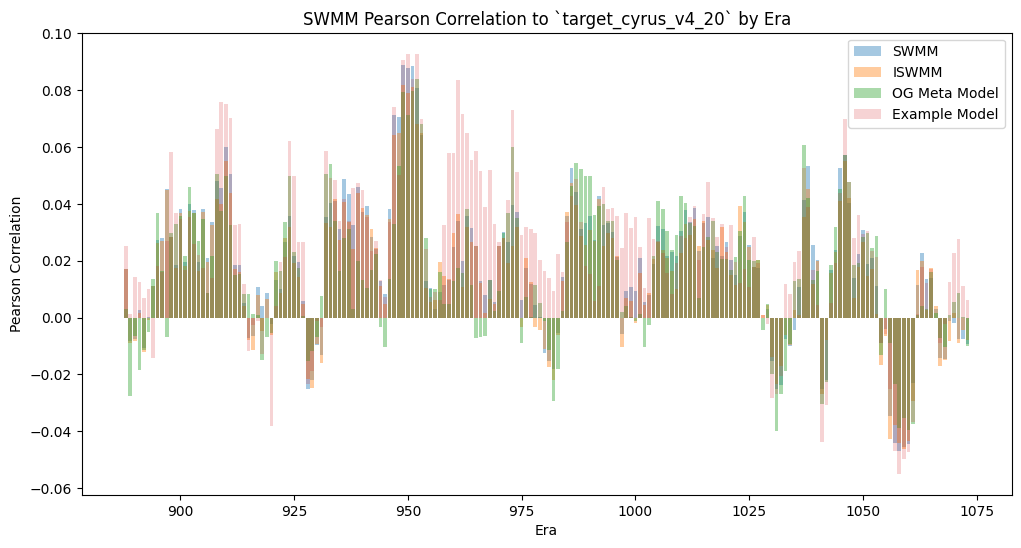

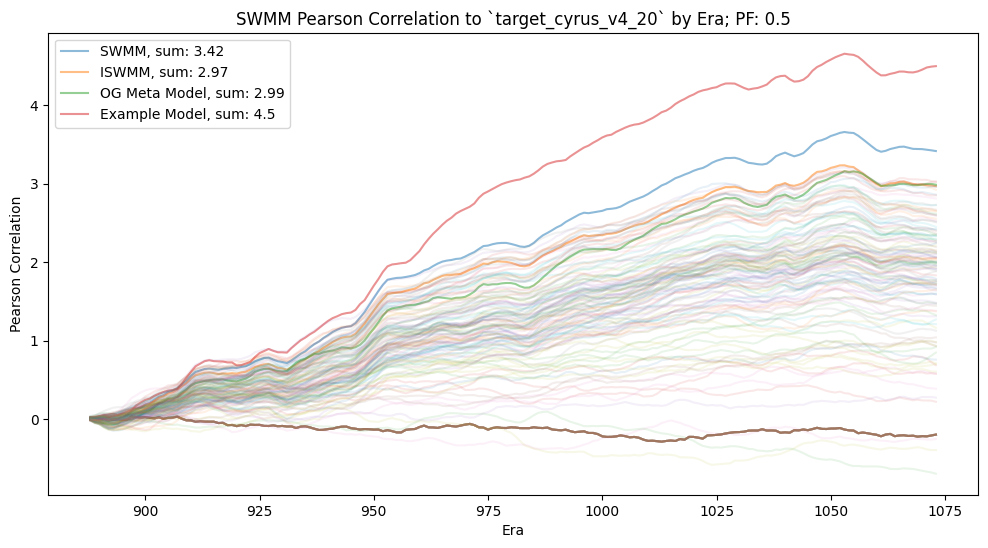

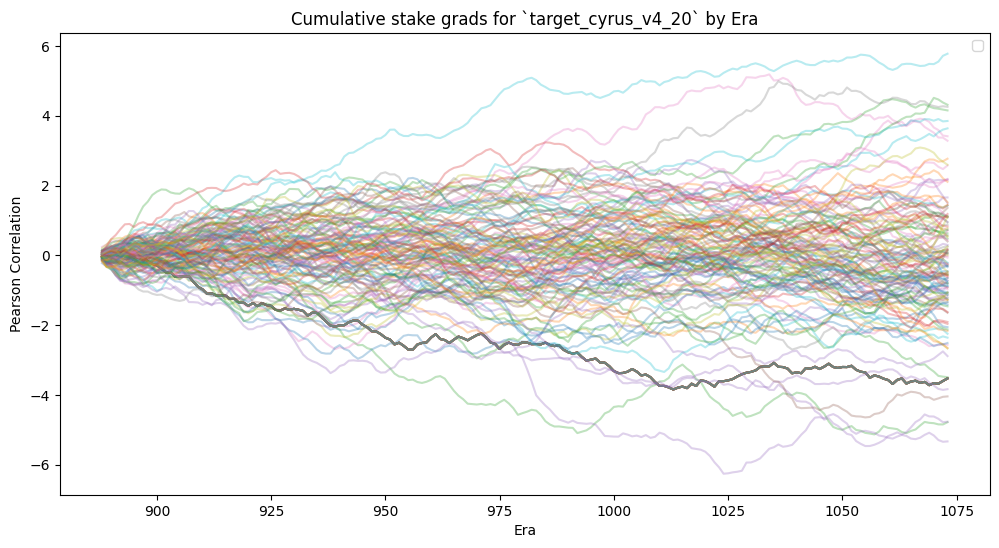

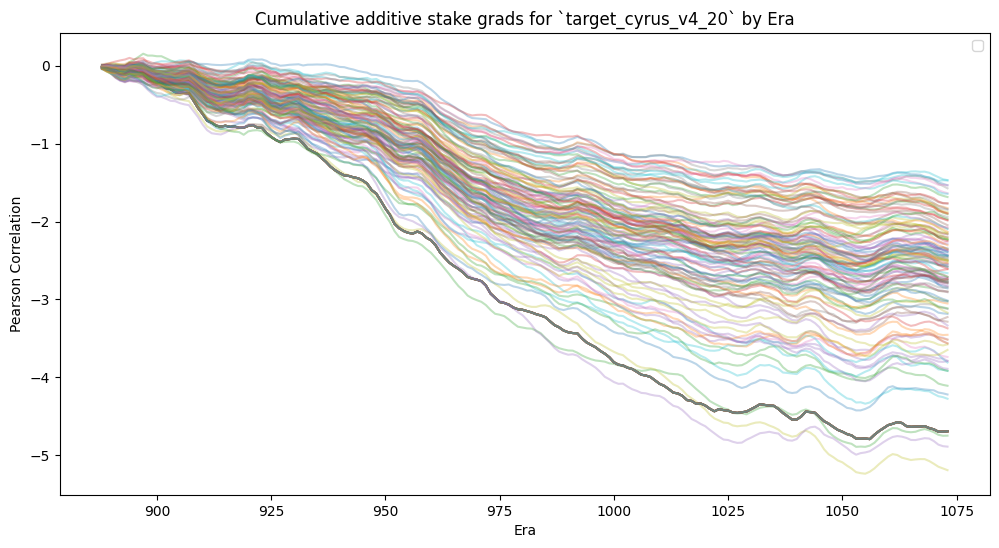

In [ ]:
# plot correlations
plt.figure(figsize=(12, 6))
plt.bar(metrics["era"], metrics["swmm_corr"], label="SWMM", alpha=0.4)
plt.bar(metrics["era"], metrics["iswmm_corr"], label="ISWMM", alpha=0.4)
plt.bar(metrics["era"], metrics["og_mm_corr"], label="OG Meta Model", alpha=0.4)
plt.bar(metrics["era"], metrics["example_model_corr"], label="Example Model", alpha=0.2)
plt.title(f"SWMM Pearson Correlation to `{PRIMARY_TARGET}` by Era")
plt.legend()
plt.xlabel("Era")
plt.ylabel("Pearson Correlation")
plt.show()


# print cumulative plot of correlations
plt.figure(figsize=(12, 6))
plt.plot(
    metrics["era"],
    metrics["swmm_corr"].cumsum(),
    label=f"SWMM, sum: {metrics['swmm_corr'].sum().round(2)}",
    alpha=0.5,
)
plt.plot(
    metrics["era"],
    metrics["iswmm_corr"].cumsum(),
    label=f"ISWMM, sum: {metrics['iswmm_corr'].sum().round(2)}",
    alpha=0.5,
)
plt.plot(
    metrics["era"],
    metrics["og_mm_corr"].cumsum(),
    label=f"OG Meta Model, sum: {metrics['og_mm_corr'].sum().round(2)}",
    alpha=0.5,
)
plt.plot(
    metrics["era"],
    metrics["example_model_corr"].cumsum(),
    label=f"Example Model, sum: {metrics['example_model_corr'].sum().round(2)}",
    alpha=0.5,
)

# plot all models
for _col in model_performance.columns:
    if _col == "era":
        continue
    label = (
        None
        if "prediction_" in _col
        else f"{_col}, sum: {model_performance[_col].sum().round(2)}"
    )
    plt.plot(
        model_performance["era"],
        model_performance[_col].cumsum(),
        label=label,
        alpha=0.1,
    )

plt.title(f"SWMM Pearson Correlation to `{PRIMARY_TARGET}` by Era; PF: {PAYOUT_FACTOR}")
plt.legend()
plt.xlabel("Era")
plt.ylabel("Pearson Correlation")
plt.show()


# plot model stake_grads: cumulative
plt.figure(figsize=(12, 6))
for _col in model_stake_grads.columns:
    if _col == "era":
        continue
    label = (
        None
        if "prediction_" in _col
        else f"{_col}, sum: {model_stake_grads[_col].sum().round(2)}"
    )
    plt.plot(
        model_stake_grads["era"],
        model_stake_grads[_col].cumsum(),
        label=label,
        alpha=0.3,
    )

plt.title(f"Cumulative stake grads for `{PRIMARY_TARGET}` by Era")
plt.legend()
plt.xlabel("Era")
plt.ylabel("Pearson Correlation")
plt.show()


# plot additive stake grads: cumulative
plt.figure(figsize=(12, 6))
for _col in model_additive_stake_grads.columns:
    if _col == "era":
        continue
    label = (
        None
        if "prediction_" in _col
        else f"{_col}, sum: {model_additive_stake_grads[_col].sum().round(2)}"
    )
    plt.plot(
        model_additive_stake_grads["era"],
        model_additive_stake_grads[_col].cumsum(),
        label=label,
        alpha=0.3,
    )

plt.title(f"Cumulative additive stake grads for `{PRIMARY_TARGET}` by Era")
plt.legend()
plt.xlabel("Era")
plt.ylabel("Pearson Correlation")
plt.show()

In [190]:
# s1T C(p1) + s2T C(p2) = (s1 + s2)T C( s1p1 + s2p))

In [152]:
(random_stake * _stake_grad).sum()

tensor(2658.9023, grad_fn=<SumBackward0>)

This means we are far from the target and the OG meta model is better; way better! 

How do we calibrate local meta model to the OG meta model?

